# Descripción del proyecto

Film Junky Union, una nueva comunidad vanguardista para los aficionados de las películas clásicas, está desarrollando un sistema para filtrar y categorizar reseñas de películas. Tu objetivo es entrenar un modelo para detectar las críticas negativas de forma automática. Para lograrlo, utilizarás un conjunto de datos de reseñas de películas de IMDB con leyendas de polaridad para construir un modelo para clasificar las reseñas positivas y negativas. Este deberá alcanzar un valor F1 de al menos 0.85.
El proyecto fue elaborado en Google Colab, debido a la necesidad de trabajar en una GPU

1  Inicialización

In [ ]:
# prompt: install spicy library

!pip install scipy
!pip install torch torchvision torchaudio


In [ ]:
import math

import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

from tqdm.auto import tqdm
from tqdm import tqdm
import math

import random
import spacy
import re
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords as nltk_stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from concurrent.futures import ProcessPoolExecutor

from torch.utils.data import DataLoader, TensorDataset

In [ ]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'
# la siguiente línea proporciona gráficos de mejor calidad en pantallas HiDPI
# %config InlineBackend.figure_format = 'retina'

plt.style.use('seaborn')

<ipython-input-3-a196e0c5df83>:6: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


In [ ]:
# esto es para usar progress_apply, puedes leer más en https://pypi.org/project/tqdm/#pandas-integration
tqdm.pandas()

2  Cargar datos

In [ ]:
from google.colab import files

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df_reviews = pd.read_csv('/content/drive/MyDrive/df_proj16/imdb_reviews.tsv', sep='\t', dtype={'votes': 'Int64'})
df_reviews.head(10)





,tconst,title_type,primary_title,original_title,start_year,end_year,runtime_minutes,is_adult,genres,average_rating,votes,review,rating,sp,pos,ds_part,idx
0,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,The pakage implies that Warren Beatty and Gold...,1,neg,0,train,8335
1,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,How the hell did they get this made?! Presenti...,1,neg,0,train,8336
2,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,There is no real story the film seems more lik...,3,neg,0,test,2489
3,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,Um .... a serious film about troubled teens in...,7,pos,1,test,9280
4,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,I'm totally agree with GarryJohal from Singapo...,9,pos,1,test,9281
5,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,This is the first movie I've seen from Singapo...,9,pos,1,test,9282
6,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,Yes non-Singaporean's can't see what's the big...,9,pos,1,test,9283
7,tt0035958,movie,'Gung Ho!': The Story of Carlson's Makin Islan...,'Gung Ho!': The Story of Carlson's Makin Islan...,1943,\N,88,0,"Drama,History,War",6.1,1240,This true story of Carlson's Raiders is more o...,2,neg,0,train,9903
8,tt0035958,movie,'Gung Ho!': The Story of Carlson's Makin Islan...,'Gung Ho!': The Story of Carlson's Makin Islan...,1943,\N,88,0,"Drama,History,War",6.1,1240,Should have been titled 'Balderdash!' Little i...,2,neg,0,train,9905
9,tt0035958,movie,'Gung Ho!': The Story of Carlson's Makin Islan...,'Gung Ho!': The Story of Carlson's Makin Islan...,1943,\N,88,0,"Drama,History,War",6.1,1240,The movie 'Gung Ho!': The Story of Carlson's M...,4,neg,0,train,9904


In [ ]:
df_reviews.shape

(47331, 17)

In [ ]:
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47331 entries, 0 to 47330
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   tconst           47331 non-null  object 
 1   title_type       47331 non-null  object 
 2   primary_title    47331 non-null  object 
 3   original_title   47331 non-null  object 
 4   start_year       47331 non-null  int64  
 5   end_year         47331 non-null  object 
 6   runtime_minutes  47331 non-null  object 
 7   is_adult         47331 non-null  int64  
 8   genres           47331 non-null  object 
 9   average_rating   47329 non-null  float64
 10  votes            47329 non-null  Int64  
 11  review           47331 non-null  object 
 12  rating           47331 non-null  int64  
 13  sp               47331 non-null  object 
 14  pos              47331 non-null  int64  
 15  ds_part          47331 non-null  object 
 16  idx              47331 non-null  int64  
dtypes: Int64(1),

Se aprecian pocos valores ausentes, sólo en las columnas average_rating y votes.            

In [ ]:
df_reviews.describe()

,start_year,is_adult,average_rating,votes,rating,pos,idx
count,47331.000000,47331.000000,47329.000000,47329.0,47331.000000,47331.000000,47331.000000
mean,1989.631235,0.001732,5.998278,25562.917323,5.484608,0.498954,6279.697999
std,19.600364,0.041587,1.494289,83670.039163,3.473109,0.500004,3605.702545
min,1894.000000,0.000000,1.400000,9.0,1.000000,0.000000,0.000000
25%,1982.000000,0.000000,5.100000,827.0,2.000000,0.000000,3162.000000
50%,1998.000000,0.000000,6.300000,3197.0,4.000000,0.000000,6299.000000
75%,2004.000000,0.000000,7.100000,13974.0,9.000000,1.000000,9412.000000
max,2010.000000,1.000000,9.700000,1739448.0,10.000000,1.000000,12499.000000


In [ ]:
corpus = df_reviews['review']

#Initialize spaCy (without 'parser' and 'ner').
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

De acuerdo a los resultados observados se detecta lo siguiente:

- La columna 'start_year', tiene una media de año de 1989, en donde el rango incluye de 1894-2010, tal vez pueda influír en que haya una gran variación en las opiniones por la cantidad de años.
- 'average_rating', se encarga de medir el promedio de clasificación de las películas, con una media de 5.99, con un rango de valores donde el minímo es 1.40 y el máximo es 9.7, la desviación estandár se encuentra en 1.49, valor relativamente cercano a la media.
- La variable de 'votes' indíca la cantidad de votos que recibe un filme, con un minimo de 9 votos y un máximo de 1739448 votos, la media se encuentra en 25562.917323 votos, se observan filmes con una cantidad excesiva de votos vs películas con baja popularidad, esto puede generar un sesgo  para el conjuntos de datos de las películas con menor popularidad.
- Variable 'pos' se refiere a las críticas negativas o positivas, con valores binarios, donde 1 se refiere a positiva y cero lo contrario. Se observa una media de 0.498954, que representa que el dataset es balanceado.


<ipython-input-12-c3c214b7527e>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_counts.index, y=class_counts.values, palette='viridis')
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


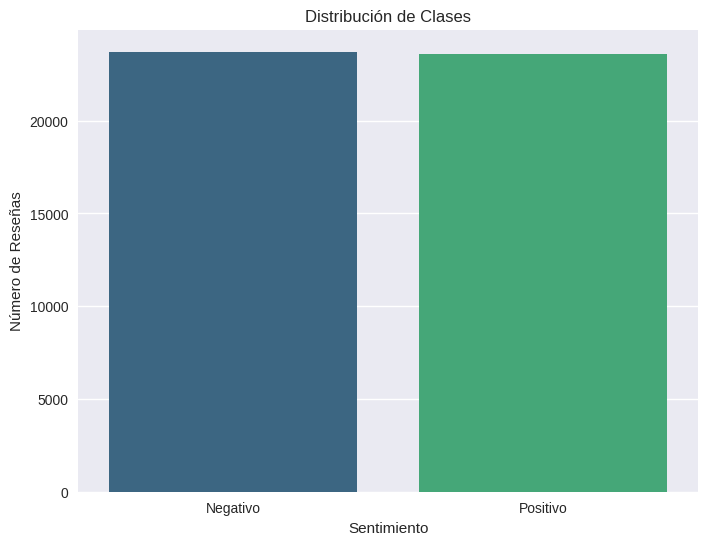

In [ ]:
#Distribución de Clases
class_counts = df_reviews['pos'].value_counts()
plt.figure(figsize=(8, 6))
sns.barplot(x=class_counts.index, y=class_counts.values, palette='viridis')
plt.title('Distribución de Clases')
plt.xlabel('Sentimiento')
plt.ylabel('Número de Reseñas')
plt.xticks(ticks=[0, 1], labels=['Negativo', 'Positivo'])
plt.show()

Se observa un balance equitativo en la distribución de las clases, equilibrio que demuestra innecesario algún metódo de tratamiento para el desequilibrio de clases.

In [ ]:
#Procesamiento de texto: Limpieza de Expresiones regulares
def clear_text(text):
    clean_text = re.sub(r'[^\w\s]', '', text)
    clean_text = re.sub(r'[^a-zA-Z\']', ' ', clean_text)
    clean_text = re.sub(r'\d+', '', clean_text)
    clean_text = " ".join(clean_text.split())
    return clean_text

In [ ]:
#Lematizar

def lemmatize(doc):
    return ' '.join([token.lemma_ for token in doc])

#Procesamiento por lotes optimizado
def batch_process(corpus, batch_size=100):  # Reducir el tamaño del lote
    processed_texts = []
    for i in tqdm(range(0, len(corpus), batch_size), desc="Procesando por lotes"):
        batch = corpus[i:i+batch_size]
        docs = list(nlp.pipe(batch, batch_size=batch_size, n_process=1))  # Procesar en un solo hilo para evitar sobrecarga
        processed_texts.extend([lemmatize(doc) for doc in docs])
    return processed_texts

# Procesar el corpus
corpus_processed = batch_process(corpus, batch_size=100)

Procesando por lotes: 100%|██████████| 474/474 [16:44<00:00,  2.12s/it]


In [ ]:
#Vectorizar con TF-IDF

import nltk

nltk.download('stopwords')
stop_words = nltk.corpus.stopwords.words('english') # Use a list instead of a set
vectorizer = TfidfVectorizer(stop_words=stop_words, max_features=10000)
tf_idf = vectorizer.fit_transform(corpus_processed)

print('El tamaño de la matriz TF-IDF:', tf_idf.shape)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


El tamaño de la matriz TF-IDF: (47331, 10000)


3  EDA

Veamos el número de películas y reseñas a lo largo de los años.

In [ ]:
fig, axs = plt.subplots(2, 1, figsize=(16, 8))

ax = axs[0]

dft1 = df_reviews[['tconst', 'start_year']].drop_duplicates() \
    ['start_year'].value_counts().sort_index()
dft1 = dft1.reindex(index=np.arange(dft1.index.min(), max(dft1.index.max(), 2021))).fillna(0)
dft1.plot(kind='bar', ax=ax)
ax.set_title('Número de películas a lo largo de los años')

ax = axs[1]

dft2 = df_reviews.groupby(['start_year', 'pos'])['pos'].count().unstack()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)

dft2.plot(kind='bar', stacked=True, label='#reviews (neg, pos)', ax=ax)

dft2 = df_reviews['start_year'].value_counts().sort_index()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)
dft3 = (dft2/dft1).fillna(0)
axt = ax.twinx()
dft3.reset_index(drop=True).rolling(5).mean().plot(color='orange', label='reviews per movie (avg over 5 years)', ax=axt)

lines, labels = axt.get_legend_handles_labels()
ax.legend(lines, labels, loc='upper left')

ax.set_title('Número de reseñas a lo largo de los años')

fig.tight_layout()

Se observa una clara tendencia de incremento de producción de películas a partir de la decáda de los 2000s, lo cuál llevo a una relación directa en el aumento a la par de reseñas durante la decáda mencionada.

Veamos la distribución del número de reseñas por película con el conteo exacto y KDE (solo para saber cómo puede diferir del conteo exacto)

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

ax = axs[0]
dft = df_reviews.groupby('tconst')['review'].count() \
    .value_counts() \
    .sort_index()
dft.plot.bar(ax=ax)
ax.set_title('Gráfico de barras de #Reseñas por película')

ax = axs[1]
dft = df_reviews.groupby('tconst')['review'].count()
sns.kdeplot(dft, ax=ax)
ax.set_title('Gráfico KDE de #Reseñas por película')

fig.tight_layout()

In [ ]:
df_reviews['pos'].value_counts()

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

ax = axs[0]
dft = df_reviews.query('ds_part == "train"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('El conjunto de entrenamiento: distribución de puntuaciones')

ax = axs[1]
dft = df_reviews.query('ds_part == "test"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('El conjunto de prueba: distribución de puntuaciones')

fig.tight_layout()

Distribución de reseñas negativas y positivas a lo largo de los años para dos partes del conjunto de datos


In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(16, 8), gridspec_kw=dict(width_ratios=(2, 1), height_ratios=(1, 1)))

ax = axs[0][0]

dft = df_reviews.query('ds_part == "train"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('El conjunto de entrenamiento: número de reseñas de diferentes polaridades por año')

ax = axs[0][1]

dft = df_reviews.query('ds_part == "train"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('El conjunto de entrenamiento: distribución de diferentes polaridades por película')

ax = axs[1][0]

dft = df_reviews.query('ds_part == "test"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('El conjunto de prueba: número de reseñas de diferentes polaridades por año')

ax = axs[1][1]

dft = df_reviews.query('ds_part == "test"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('El conjunto de prueba: distribución de diferentes polaridades por película')

fig.tight_layout()

Tanto el conjunto de entrenamiento como de pruebas muestran resultados simílares, lo cual indica que existe una consistencia entre ambas distribuciones. La explicación anterior demuestra que el modelo cuenta con datos representativos durante el entrenamiento y la evaluación.
Al detectar que las distribuciones son casi iguales, el modelo no sólo aprende de patrones en el conjunto de entrenamiento, evitando el riesgo de un sobreajuste.

4  Procedimiento de evaluación

In [ ]:
import sklearn.metrics as metrics
def evaluate_model(model, train_features, train_target, test_features, test_target):

    eval_stats = {}

    fig, axs = plt.subplots(1, 3, figsize=(20, 6))

    for type, features, target in (('train', train_features, train_target), ('test', test_features, test_target)):

        eval_stats[type] = {}

        pred_target = model.predict(features)
        pred_proba = model.predict_proba(features)[:, 1]

        # F1
        f1_thresholds = np.arange(0, 1.01, 0.05)
        f1_scores = [metrics.f1_score(target, pred_proba>=threshold) for threshold in f1_thresholds]

        # ROC
        fpr, tpr, roc_thresholds = metrics.roc_curve(target, pred_proba)
        roc_auc = metrics.roc_auc_score(target, pred_proba)
        eval_stats[type]['ROC AUC'] = roc_auc

        # PRC
        precision, recall, pr_thresholds = metrics.precision_recall_curve(target, pred_proba)
        aps = metrics.average_precision_score(target, pred_proba)
        eval_stats[type]['APS'] = aps

        if type == 'train':
            color = 'blue'
        else:
            color = 'green'

        # Valor F1
        ax = axs[0]
        max_f1_score_idx = np.argmax(f1_scores)
        ax.plot(f1_thresholds, f1_scores, color=color, label=f'{type}, max={f1_scores[max_f1_score_idx]:.2f} @ {f1_thresholds[max_f1_score_idx]:.2f}')
        # establecer cruces para algunos umbrales
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(f1_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(f1_thresholds[closest_value_idx], f1_scores[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('threshold')
        ax.set_ylabel('F1')
        ax.legend(loc='lower center')
        ax.set_title(f'Valor F1')

        # ROC
        ax = axs[1]
        ax.plot(fpr, tpr, color=color, label=f'{type}, ROC AUC={roc_auc:.2f}')
        # establecer cruces para algunos umbrales
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(roc_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(fpr[closest_value_idx], tpr[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
        ax.set_xlim([-0.02, 1.02])
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        ax.legend(loc='lower center')
        ax.set_title(f'Curva ROC')

        # PRC
        ax = axs[2]
        ax.plot(recall, precision, color=color, label=f'{type}, AP={aps:.2f}')
        # establecer cruces para algunos umbrales
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(pr_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(recall[closest_value_idx], precision[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('recall')
        ax.set_ylabel('precision')
        ax.legend(loc='lower center')
        ax.set_title(f'PRC')

        eval_stats[type]['Accuracy'] = metrics.accuracy_score(target, pred_target)
        eval_stats[type]['F1'] = metrics.f1_score(target, pred_target)

    df_eval_stats = pd.DataFrame(eval_stats)
    df_eval_stats = df_eval_stats.round(2)
    df_eval_stats = df_eval_stats.reindex(index=('Exactitud', 'F1', 'APS', 'ROC AUC'))

    print(df_eval_stats)

    return

5  Normalización

Suponemos que todos los modelos a continuación aceptan textos en minúsculas y sin dígitos, signos de puntuación, etc.

In [ ]:
 # <escribe tu código aquí>

def preprocess_text_series(series):
    return series.str.lower().replace(r'\d+', '', regex=True).replace(r'[^\w\s]', '', regex=True)

df_reviews['review_norm'] = preprocess_text_series(df_reviews['review'])

6  División entrenamiento / prueba

Por fortuna, todo el conjunto de datos ya está dividido en partes de entrenamiento/prueba; 'ds_part' es el indicador correspondiente.


In [ ]:
df_reviews_train = df_reviews.query('ds_part == "train"').copy()
df_reviews_test = df_reviews.query('ds_part == "test"').copy()

train_target = df_reviews_train['pos'].values
test_target = df_reviews_test['pos'].values

print(df_reviews_train.shape)
print(df_reviews_test.shape)


Se observa que las ambas dimensiones de los 2 conjuntos son simílares, lo cual indica que hay una representación equilibrada de los datos en dichas fases. El hecho de contar con un tamaño simílar en ambos conjuntos aumenta la confiabilidad de las métricas de evaluación, y permite que el modelo sea entrenado robustamente sin que el conjunto de prueba sea subrepresentado.




7  Trabajar con modelos

7.1  Modelo 0 - Constante

In [ ]:
from sklearn.dummy import DummyClassifier

In [ ]:
tfidf_vectorizer_1 = TfidfVectorizer(stop_words=stop_words)

train_features_1 = tfidf_vectorizer_1.fit_transform(df_reviews_train['review_norm'])
test_features_1 = tfidf_vectorizer_1.transform(df_reviews_test['review_norm'])

In [ ]:
model_0 = DummyClassifier(strategy="most_frequent")


In [ ]:
model_0.fit(train_features_1, train_target)

In [ ]:
#Evaluar modelo
evaluate_model(model_0, train_features_1, train_target, test_features_1, test_target)

7.2  Modelo 1 - NLTK, TF-IDF y LR

TF-IDF


In [ ]:
import nltk

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

from nltk.corpus import stopwords
from sklearn.metrics import accuracy_score, f1_score, average_precision_score, roc_auc_score

In [ ]:
nltk.download('stopwords')
stop_words = stopwords.words('english')

In [ ]:
tfidf_vectorizer_2 = TfidfVectorizer(stop_words=stop_words)

In [ ]:
train_features = tfidf_vectorizer_2.fit_transform(df_reviews_train['review_norm'])
test_features = tfidf_vectorizer_2.transform(df_reviews_test['review_norm'])

In [ ]:
model_2 = LogisticRegression()

#Entrenar modelo
model_2.fit(train_features, train_target)

In [ ]:
# Evaluar el modelo
def evaluate_model(model_2, train_features, train_target, test_features, test_target):
    train_predictions = model_2.predict(train_features)
    test_predictions = model_2.predict(test_features)

    metrics = {
        'Exactitud': accuracy_score(test_target, test_predictions),
        'F1': f1_score(test_target, test_predictions),
        'APS': average_precision_score(test_target, test_predictions),
        'ROC AUC': roc_auc_score(test_target, model_2.predict_proba(test_features)[:, 1])
    }

    for metric, score in metrics.items():
        print(f'{metric} - Train: {accuracy_score(train_target, model_2.predict(train_features)):.2f}, Test: {score:.2f}')


evaluate_model(model_2, train_features, train_target, test_features, test_target)

7.3  Modelo 3 - spaCy, TF-IDF y LR

In [ ]:
import spacy

nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner', 'textcat'])

In [ ]:
def text_preprocessing_3(texts, batch_size=10000, n_process=4):
    #Usar n_process para procesamiento paralelo
    tokens = []
    for doc in nlp.pipe(texts, batch_size=batch_size, n_process=n_process):
        tokens.append(' '.join([token.lemma_ for token in doc if not token.is_stop]))  #Lematización
    return tokens

In [ ]:
#Preprocesamiento de textos
train_processed_3 = text_preprocessing_3(df_reviews_train['review_norm'])
test_processed_3 = text_preprocessing_3(df_reviews_test['review_norm'])

In [ ]:
#Vectorización TF-IDF
tfidf_vectorizer_3 = TfidfVectorizer(stop_words=stop_words, ngram_range=(1, 2), max_df=0.9, min_df=5)
train_features_3 = tfidf_vectorizer_3.fit_transform(train_processed_3)
test_features_3 = tfidf_vectorizer_3.transform(test_processed_3)

In [ ]:
model_3 = LogisticRegression(max_iter=100, solver='liblinear', C=0.5)

# Entrenar el modelo
model_3.fit(train_features_3, train_target)

In [ ]:
#Evaluar modelo
def evaluate_model(model, train_features, train_target, test_features, test_target):
    train_predictions = model.predict(train_features)
    test_predictions = model.predict(test_features)

    metrics = {
        'Exactitud': accuracy_score(test_target, test_predictions),
        'F1': f1_score(test_target, test_predictions),
        'APS': average_precision_score(test_target, test_predictions),
        'ROC AUC': roc_auc_score(test_target, model.predict_proba(test_features)[:, 1])
    }

    for metric, score in metrics.items():
        print(f'{metric} - Train: {accuracy_score(train_target, model.predict(train_features)):.2f}, Test: {score:.2f}')

#Llamar a la función de evaluación
evaluate_model(model_3, train_features_3, train_target, test_features_3, test_target)

7.4  Modelo 4 - spaCy, TF-IDF y LGBMClassifier

In [ ]:
from lightgbm import LGBMClassifier

In [ ]:
def text_preprocessing_4(texts, batch_size=10000, n_process=4):
    # Usar n_process para procesamiento paralelo
    tokens = []
    for doc in nlp.pipe(texts, batch_size=batch_size, n_process=n_process):
        tokens.append(' '.join([token.lemma_ for token in doc if not token.is_stop]))  # Lematización
    return tokens

# Preprocesamiento de textos
train_processed_4 = text_preprocessing_4(df_reviews_train['review_norm'])
test_processed_4 = text_preprocessing_4(df_reviews_test['review_norm'])

In [ ]:
#Vectorización TF-IDF
tfidf_vectorizer_4 = TfidfVectorizer(stop_words=stop_words, ngram_range=(1, 2), max_df=0.9, min_df=5)
train_features_4 = tfidf_vectorizer_4.fit_transform(train_processed_4)
test_features_4 = tfidf_vectorizer_4.transform(test_processed_4)

In [ ]:
model_4 = LGBMClassifier(num_leaves=31, learning_rate=0.05, n_estimators=100)

# Entrenar el modelo
model_4.fit(train_features_4, train_target)

# Evaluar el modelo
def evaluate_model_lgbm(model, train_features, train_target, test_features, test_target):
    train_predictions = model.predict(train_features)
    test_predictions = model.predict(test_features)

    metrics = {
        'Exactitud': accuracy_score(test_target, test_predictions),
        'F1': f1_score(test_target, test_predictions),
        'APS': average_precision_score(test_target, test_predictions),
        'ROC AUC': roc_auc_score(test_target, model.predict_proba(test_features)[:, 1])
    }

    for metric, score in metrics.items():
        print(f'{metric} - Train: {accuracy_score(train_target, model.predict(train_features)):.2f}, Test: {score:.2f}')

# Llamar a la función de evaluación
evaluate_model_lgbm(model_4, train_features_4, train_target, test_features_4, test_target)

7.5  Modelo 9 - BERT

In [ ]:
import torch
import transformers
from tqdm import tqdm
import numpy as np
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
from transformers import BertModel, BertTokenizer, BertConfig


In [ ]:
#Carga del tokenizer y del modelo preentrenado
tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased')
config = transformers.BertConfig.from_pretrained('bert-base-uncased')
model_9 = transformers.BertModel.from_pretrained('bert-base-uncased')

In [ ]:
# Definir un modelo con una capa de clasificación encima de BERT
class BertClassifier(nn.Module):
    def __init__(self, bert_model, num_labels=2):
        super(BertClassifier, self).__init__()
        self.bert = bert_model
        self.classifier = nn.Linear(bert_model.config.hidden_size, num_labels)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        cls_output = outputs.last_hidden_state[:, 0, :]  # Tomamos el token [CLS]
        logits = self.classifier(cls_output)
        return logits

# Crear una instancia del modelo con clasificación
model_9_with_classifier = BertClassifier(model_9)

# Función para convertir texto a embeddings usando BERT
def BERT_text_to_embeddings(texts, max_length=512, batch_size=100, force_device=None, disable_progress_bar=False):
    # Convertir texto a ids de tokens y máscaras de atención
    ids_list = []
    attention_mask_list = []

    for text in texts:
        tokens = tokenizer.encode_plus(
            text,
            max_length=max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        ids_list.append(tokens['input_ids'].squeeze().tolist())
        attention_mask_list.append(tokens['attention_mask'].squeeze().tolist())

    if force_device is not None:
        device = torch.device(force_device)
    else:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    model_9_with_classifier.to(device)
    if not disable_progress_bar:
        print(f'Uso del dispositivo {device}.')

    # Crear DataLoader para procesamiento por lotes
    ids_tensor = torch.LongTensor(ids_list)
    attention_mask_tensor = torch.LongTensor(attention_mask_list)
    dataset = TensorDataset(ids_tensor, attention_mask_tensor)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

    embeddings = []

    model_9_with_classifier.eval()
    with torch.no_grad():
        for ids_batch, attention_mask_batch in tqdm(dataloader, disable=disable_progress_bar):
            ids_batch = ids_batch.to(device)
            attention_mask_batch = attention_mask_batch.to(device)

            # Obtener logits en lugar de embeddings
            logits = model_9_with_classifier(input_ids=ids_batch, attention_mask=attention_mask_batch)
            probs = torch.softmax(logits, dim=1)  # Convertir logits a probabilidades
            embeddings.append(probs.detach().cpu().numpy())

    return np.concatenate(embeddings)

In [ ]:
train_features_9 = BERT_text_to_embeddings(df_reviews_train['review_norm'].tolist())

In [ ]:
print(df_reviews_train['review_norm'].shape)
print(train_features_9.shape)
print(train_target.shape)

In [ ]:
#Tokenización y generación de tensores para el entrenamiento y prueba
def tokenize_texts(texts, tokenizer, max_len=128):
    tokens = tokenizer(texts, max_length=max_len, truncation=True, padding=True, return_tensors='pt')
    return tokens['input_ids'], tokens['attention_mask']

#Tokenizar textos de prueba
test_input_ids, test_attention_mask = tokenize_texts(df_reviews_test['review_norm'].tolist(), tokenizer)

#Crear dataset y dataloader
test_dataset = TensorDataset(test_input_ids, test_attention_mask, torch.tensor(test_target))
test_dataloader = DataLoader(test_dataset, batch_size=16)

#Evaluar el modelo en el conjunto de prueba
def evaluate_model(model, dataloader):
    model.eval()
    predictions, targets = [], []
    with torch.no_grad():
        for batch in dataloader:
            input_ids, attention_mask, labels = batch
            input_ids, attention_mask, labels = input_ids.to('cuda'), attention_mask.to('cuda'), labels.to('cuda')
            logits = model(input_ids, attention_mask)
            preds = torch.argmax(logits, dim=1).cpu().numpy()
            predictions.extend(preds)
            targets.extend(labels.cpu().numpy())
    return np.array(predictions), np.array(targets)

In [ ]:
#Evaluar conjunto de prueba
test_predictions, test_targets = evaluate_model(model_9_with_classifier, test_dataloader)

In [ ]:
#Calcular métricas para prueba
test_acc = accuracy_score(test_targets, test_predictions)
test_f1 = f1_score(test_targets, test_predictions, average='weighted')
test_aps = average_precision_score(test_targets, test_predictions)
test_roc_auc = roc_auc_score(test_targets, test_predictions)



In [ ]:
print(f'Exactitud - Test: {test_acc}')
print(f'F1 - Test: {test_f1}')
print(f'APS - Test: {test_aps}')
print(f'ROC AUC - Test: {test_roc_auc}')

In [ ]:
# si ya obtuviste los insertados, te recomendamos guardarlos para tenerlos listos si
# np.savez_compressed('features_9.npz', train_features_9=train_features_9, test_features_9=test_features_9)

# y cargar...
# with np.load('features_9.npz') as data:
#     train_features_9 = data['train_features_9']
#     test_features_9 = data['test_features_9']

8  Mis reseñas

In [ ]:
import pandas as pd
!pip install spacy
import spacy

# Load the spaCy English language model
nlp = spacy.load("en_core_web_sm")

# puedes eliminar por completo estas reseñas y probar tus modelos en tus propias reseñas; las que se muestran a continuación son solo ejemplos

my_reviews = pd.DataFrame([
    'I did not simply like it, not my kind of movie.',
    'Well, I was bored and felt asleep in the middle of the movie.',
    'I was really fascinated with the movie',
    'Even the actors looked really old and disinterested, and they got paid to be in the movie. What a soulless cash grab.',
    'I didn\'t expect the reboot to be so good! Writers really cared about the source material',
    'The movie had its upsides and downsides, but I feel like overall it\'s a decent flick. I could see myself going to see it again.',
    'What a rotten attempt at a comedy. Not a single joke lands, everyone acts annoying and loud, even kids won\'t like this!',
    'Launching on Netflix was a brave move & I really appreciate being able to binge on episode after episode, of this exciting intelligent new drama.'
], columns=['review'])

"""
my_reviews = pd.DataFrame([
    'Simplemente no me gustó, no es mi tipo de película.',
    'Bueno, estaba aburrido y me quedé dormido a media película.',
    'Estaba realmente fascinada con la película',
    'Hasta los actores parecían muy viejos y desinteresados, y les pagaron por estar en la película. Qué robo tan desalmado.',
    '¡No esperaba que el relanzamiento fuera tan bueno! Los escritores realmente se preocuparon por el material original',
    'La película tuvo sus altibajos, pero siento que, en general, es una película decente. Sí la volvería a ver',
    'Qué pésimo intento de comedia. Ni una sola broma tiene sentido, todos actúan de forma irritante y ruidosa, ¡ni siquiera a los niños les gustará esto!',
    'Fue muy valiente el lanzamiento en Netflix y realmente aprecio poder seguir viendo episodio tras episodio de este nuevo drama tan emocionante e inteligente.'
], columns=['review'])
"""

def clear_text(text):
    # your code here
    return text

def lemmatize(doc):
    return ' '.join([token.lemma_ for token in doc])

# Apply nlp to the text before calling lemmatize
my_reviews['review_norm'] = my_reviews['review'].apply(lambda x: lemmatize(nlp(clear_text(x)))) # <escribe aquí la misma lógica de normalización que para el conjunto de datos principal>

my_reviews

8.1  Modelo 2

In [ ]:
texts = my_reviews['review_norm']

my_reviews_pred_prob = model_2.predict_proba(tfidf_vectorizer_2.transform(texts))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

8.2  Modelo 3

In [ ]:
texts = my_reviews['review_norm']

my_reviews_pred_prob = model_3.predict_proba(tfidf_vectorizer_3.transform(texts.apply(lambda x: text_preprocessing_3(x))))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

8.3  Modelo 4

In [ ]:
texts = my_reviews['review_norm']

tfidf_vectorizer_4 = tfidf_vectorizer_3
my_reviews_pred_prob = model_4.predict_proba(tfidf_vectorizer_4.transform(texts.apply(lambda x: text_preprocessing_3(x))))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

8.4  Modelo 9

In [ ]:
texts = my_reviews['review_norm']
my_reviews_features_9 = BERT_text_to_embeddings(texts, disable_progress_bar=True)

#Obtener las probabilidades de clasificación
my_reviews_pred_prob = my_reviews_features_9[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

9  Conclusiones

Una vez ejecutados los distintos modelos, estos han sido los resultados:

- Modelo 0 - DummyClassifier (Estrategia: "most_frequent")

Exactitud: Train: 0.50, Test: 0.50

F1: Train: 0.50, Test: 0.00

APS: Train: 0.50, Test: 0.50

ROC AUC: Train: 0.50, Test: 0.50

Debido a que el modelo DummyClassifier maneja la estrategia de clase mayoritaría, que se comporta como un modelo de referencia básico. El modelo tiende a predecir la clase más recuente, lo cual no ayuda para el objetivo del proyecto, porque no consigue identifícar las críticas negativas, y el valor de F1 es bajo.

- Modelo 2 - TF-IDF y Logistic Regression

Exactitud: Train: 0.94, Test: 0.88

F1: Train: 0.94, Test: 0.88

APS: Train: 0.94, Test: 0.84

ROC AUC: Train: 0.94, Test: 0.95

Estos modelos muestran un performance alto, en entrenamiento y la prueba, tanto en accuracy y en f1 tiene un alto número mayor a 0.85, demostrando que son modelos ideales para la clasificación de reseñas. Se aprecia un modelo con buen ajuste.

- Modelo 3 - spaCy, TF-IDF y Logistic Regression

Exactitud: Train: 0.92, Test: 0.87

F1: Train: 0.92, Test: 0.87

APS: Train: 0.92, Test: 0.82

ROC AUC: Train: 0.92, Test: 0.94

La integración de spacy para la lematización de este modelo tiene un rendimiento parecido al del Modelo 2, con una ligera disminución  en el accuracy y en el f1. La incorporación de lematización no ha resultado en una mejora con respecto al modelo anterior.

- Modelo 4 - spaCy, TF-IDF y LGBMClassifier

Exactitud: Train: 0.87, Test: 0.83

F1: Train: 0.87, Test: 0.84

APS: Train: 0.87, Test: 0.78

ROC AUC: Train: 0.87, Test: 0.92

Este modelo al parecer tiene un buen rendimiento, pero arroja cifras inferiores de f1 y exactitud, contrariamente el ROC AUC es alto, dicha conducta significa una alta capacidad de distinción entre clases, sin embargo, exíste el riesgo no levar una captura correcta de las críticas negativas, como los modelos de regresión logística.

- Modelo 9 - BERT

Exactitud: Test: 0.50

F1: Test: 0.39

APS: Test: 0.50

ROC AUC: Test: 0.50

El modelo BERT tiene el peor rendimiento, las métricas son bajas con respecto a los demas modelos.

Podemos concluir que los modelos con mejor rendimiento fueron el 2 y 3, que se basan en Logistic Regression y TF-IDF, los cuales tienen las mejores métricas  en f1 y en accuracy, el f1 logra un valor de al menos 0.85. Fueron los mejores modelos para la detección de críticas negativas.